In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }")

In [2]:
from collections import deque
from graphviz import Digraph
from statistics import median
from time import process_time

# Splay Trees

In diesem Notebook wird eine bestimmte Art von selbstbalancierenden Bäumen gezeigt, die *Splay Trees*. Diese Datenstruktur wurde [1985 von Sleator und Tarjan eingeführt](http://www.cs.cmu.edu/~sleator/papers/self-adjusting.pdf "D. D. Sleator, R. E. Tarjan (1985): Self-Adjusting Binary Search Trees. Journal of the ACM, 32(3) 652-686"). Im Gegensatz zu anderen selbstbalancierenden Bäumen wie *AVL-Bäumen* wird bei Splay Trees nicht gefordert, dass der Baum zu allen Zeiten so gut wie möglich balanciert ist. Stattdessen wird der Baum dahingehend optimiert, dass häufig verwendete Elemente nahe an der Wurzel sind.

Auf Basis dieser Bäume soll später eine alternative Implementierung von Mengen in der Programmiersprache Python entstehen. In der Referenzimplementierung *CPython* sind [Mengen auf Basis von *Hashtabellen* implementiert](https://github.com/python/cpython/blob/41c57b335330ff48af098d47e379e0f9ba09d233/Objects/setobject.c "G. v. Rossum et al. (2019): cpython/Objects/setobject.c, GitHub"). Viele andere weit verbreitete Implementierungen anderer Programmiersprachen benutzen für Mengen ebenfalls Hashtabellen oder haben dies zumindest als Option, wie in [Java](https://docs.oracle.com/en/java/javase/13/docs/api/java.base/java/util/Set.html "Oracle Corp. (2019): Set (Java SE13 & JDK 13)"), [.NET (C#)](https://docs.microsoft.com/en-us/dotnet/api/system.collections.generic.iset-1?view=netframework-4.8, "Microsoft Corp. (2019): ISet<T> Interface (System.Collections.Generic), Microsoft Docs"), [JavaScript](https://v8.dev/blog/hash-code "Sathya Gunasekaran (2018): Optimizing hash tables: hiding the hash code, V8 Blog") oder [PHP](https://www.php.net/manual/en/class.ds-set.php "The PHP Group (2019): PHP: Set, Manual"). Jedoch macht die Verwendung von Bäumen für Mengen einige mengenlastige Programmierprobleme einfacher zu lösen, da diese Mengen *geordnet* sind und somit beispielsweise ein einfach zu bestimmendes Minimum und ein Maximum haben.

Die reine Datenstruktur – ohne Operationen – ist bei Splay Trees genauso wie bei regulären geordneten binären Bäumen definiert: $\text{Node}(p, l, r)$ ist ein Baum, wobei
- $p$ eine Nutzlast (payload) ist,
- $l$ der linke Teilbaum ist und
- $r$ der rechte Teilbaum ist.

In [3]:
class Node:
    def __init__(self, payload, left, right):
        self.payload = payload
        self.left = left
        self.right = right

Wir verlangen dabei:

- Für alle Nutzlasten aus dem linken Teilbaum $l$ gilt, dass sie kleiner als die Nutzlast $p$ sind.
- Für alle Nutzlasten aus dem rechten Teilbaum $r$ gilt, dass sie größer als die Nutzlast $p$ sind.

Diese Aussagen können auch als $l < p < r$ formuliert werden.

Die Betrachtung des Falls, dass eine Nutzlast in einem Teilbaum $l, r$ gleich der Nutzlast $p$ ist, entfällt, da Mengen keine doppelten Elemente enthalten. Diese Forderung impliziert außerdem, dass die Nutzlasten geordnet werden können. Wir behandeln später, wie wir beliebigen Nutzlasten in Python eine Ordnung geben können.

Wir definieren zunächst die Methode `graph`, die einen Baum auf Basis von *GraphViz* visualisiert. Dies erleichtert später die Erklärungen anderer Operationen. `graph` benutzt `_graph`, eine Methode, die einem bestehenden Graphen die Knoten hinzufügt. `_graph` nimmt zusätzlich eine Menge von benutzten Schlüsseln für die Knoten und einen Zähler, der Schlüssel für leere Blätter im Baum liefert. `graph` nimmt optional eine Liste von Objekten, die ebenfalls `_graph` unterstützen. Dies können wir benutzen, um eine Transformation im Baum zu zeigen. Zur besseren Illustrierung kann dazwischen ein Objekt der Klasse `Method` benutzt werden, die wir ebenfalls definieren. Wir benötigen ebenfalls zum Illustrieren einen Baum, der nur ein Kind hat, den `UnaryTree`.

In [4]:
def graph(self, additionals = []):
    dot = Digraph()
    used, key = self._graph(dot, set(), 0)
    for el in additionals:
        used, key = el._graph(dot, used, key)
    return dot

def _graph(self, dot, used, key):
    used.add(id(self))
    dot.node(str(id(self)), label=str(self.payload))
    if not (self.left is None and self.right is None):
        for node in self.left, self.right:
            if node is not None:
                dot.edge(str(id(self)), str(id(node)))
                used, key = node._graph(dot, used, key)
            else:
                while True:
                    key += 1
                    if key not in used:
                        break
                used.add(key)
                dot.node(str(key), shape="point")
                dot.edge(str(id(self)), str(key))
    return used, key

Node.graph = graph
Node._graph = _graph
del graph
del _graph

class Method:
    def __init__(self, name):
        self.name = name
    
    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name) + " ⇒", shape="rectangle", style="dotted")
        return used, key

class UnaryTree:
    def __init__(self, name, child):
        self.name = name
        self.child = child
    
    def graph(self, additionals = []):
        dot = Digraph()
        used, key = self._graph(dot, set(), 0)
        for el in additionals:
            used, key = el._graph(dot, used, key)
        return dot
    
    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name), shape="triangle")
        if not self.child is None:
            dot.edge(str(id(self)), str(id(self.child)))
            used, key = self.child._graph(dot, used, key)
        return used, key

## Splaying

Die Besonderheit von Splay Trees ist, dass mit allen Baumoperationen, die ein Element im Baum lokalisieren, eine besondere Operation, der *Splay*, durchgeführt wird. Mit Baumoperationen, die ein Element im Baum lokalisieren, sind alle Operationen auf den Baum gemeint, die den Baum auf der Suche nach einem Element oder auf der Suche nach dem richtigen Ort für ein Element durchsuchen. Dazu gehören das Einfügen, Löschen und Finden von Elementen.

Der Splay ist eine Funktion, die einen Baum dahingehend modifiziert, dass ein Knoten, der schon im Baum enthalten ist, die neue Wurzel des Baums wird:

$$\text{splay}: \text{Node} \times \text{Node} \to \text{Node}$$

Wir arbeiten mit dem *Top-Down*-Ansatz, bei dem wir von der Wurzel aus so lange Knoten beiseite legen, bis der zu splayende Knoten die Wurzel darstellt, und diese beiseite gelegten Knoten wieder unterordnen. Dieser Ansatz wurde in der ursprünglichen Veröffentlichung bereits beschrieben (S. 667ff.), aber erst [1987 von Mäkinen als in Komplexität etwas begrenzter analysiert](https://link.springer.com/article/10.1007%2FBF01933728 "E. Mäkinen (1987): On top-down splaying. BIT Numerical Mathematics, 27 330-339 (SpringerLink)").

Beim Top-Down-Splaying werden die drei Bäume $L, M, R$ (links, mitte, rechts) betrachtet. Der Baum, der bearbeitet wird, ist $M$. Wenn Knoten beiseite gelegt werden, so werden sie in $L$ und $R$ abgelegt. In $L$ kommen die Elemente, die kleiner als der zu splayende Knoten sind, in $R$ die, die größer sind. Dabei bleiben der rechteste Knoten von $L$ und der linkeste Knoten von $R$ immer frei, sodass dort leicht angefügt werden kann.

Der Splay findet schrittweise statt, in jedem Schritt werden zwei Knoten beiseite gelegt. Sollte der Knoten auf der zweitobersten Ebene sein, so wird natürlich nur noch ein Knoten beiseite gelegt. Diesen Schritt behandeln wir zuerst. Ist der Knoten dabei das linke Kind seines Elternknotens, so bezeichnen wir diesen Schritt als *Zig*.

### Zig und Zag

Die folgende Grafik illustriert den Schritt. Dreiecke stehen hier für ganze Bäume.

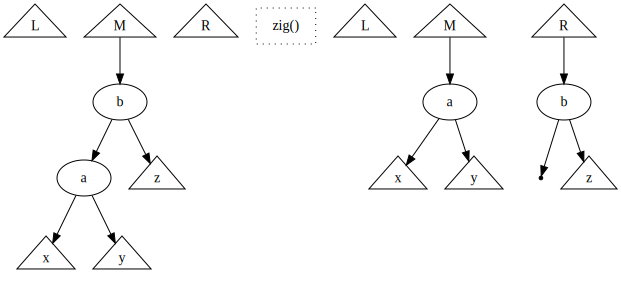

In [5]:
x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", a1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", b1); r1 = UnaryTree("R", None)

x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", None, z2)
l2 = UnaryTree("L", None); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", b2)

dot = l1.graph([m1, r1, Method("zig()"), l2, m2, r2])
for subtree in x1, y1, z1, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel, wobei $b$ gemeinsam mit seinem rechten Teilbaum $z$ links unten an $R$ angefügt wird. Die Ordnung bleibt erhalten, da $b > a$ ist, und da alle Elemente, die zuvor schon in $R$ waren, auch größer als $b$ sind.

Formal definieren wir $\text{zig}()$ unter der Angabe der momentanen Extrema in $L, R$ als Parameter als

$$\text{Node}(b, \text{Node}(a, x, y), z).\text{zig}(\text{max_}L, \text{min_}R) = \text{new_min_}R := \text{Node}(b, \text{Nil}, z); \text{min_}R.\text{left} := \text{new_min_}R; (\text{min_}L, \text{Node}(a, x, y), \text{new_min_}R)$$

wobei wir ein Tripel aus dem ungeänderten Maximum in $L$, aus der neuen Mitte und dem neuen Minimum in $R$ zurückgeben. Diese unveränderte Rückgabe erleichtert später die Definition des Splays als ganzen.

In Code definieren wir:

In [6]:
def _zig(self, max_less, min_greater):
    min_greater.left = self
    min_greater = self
    self = self.left
    min_greater.left = None
    return self, max_less, min_greater

Node._zig = _zig
del _zig

Um das vergleichsweise teure Konstruieren neuer Objekte zu vermeiden, schreiben wir lediglich die Referenzen um. Weniger geschrieben würde auch, wenn wir, statt lokale Variablen zu überschreiben, die neuen Werte direkt zurückgeben würden. Wir werden aber später die Schritte ohnehin in eine Methode schreiben, sodass dies nur die Lesbarkeit behindern würde.

Ähnlich definieren wir *Zag*, bei dem der zu splayende Knoten das rechte Kind der Wurzel ist. Hier modifizieren wir das Maximum in $L$.

$$\text{Node}(b, x, \text{Node}(a, y, z)).\text{zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, x, \text{Nil}); \text{max_L}.\text{right} := \text{new_max_}L; (\text{new_max_}L, \text{Node}(a, y, z), \text{min_}R)$$

In [7]:
def _zag(self, max_less, min_greater):
    max_less.right = self
    max_less = self
    self = self.right
    max_less.right = None
    return max_less, self, min_greater

Node._zag = _zag
del _zag

### Zig-Zig und Zag-Zag

Als nächstes behandeln wir den Fall, dass der Knoten wenigstens zwei Ebenen von der Wurzel entfernt ist, und sowohl der Knoten als auch sein Elternknoten ein linkes Kind sind. Die Operation, die auf diese Ausgangssituation anzuwenden ist, bezeichnen wir als *Zig-Zig*. Diese Operation sieht so aus:

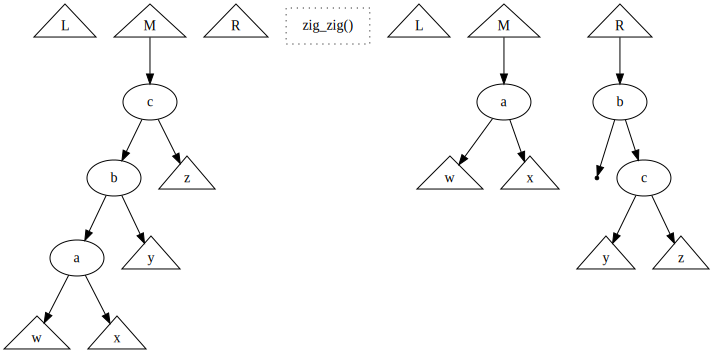

In [8]:
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", w1, x1); b1 = Node("b", a1, y1); c1 = Node("c", b1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", c1); r1 = UnaryTree("R", None)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", w2, x2); c2 = Node("c", y2, z2); b2 = Node("b", None, c2)
l2 = UnaryTree("L", None); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", b2)

dot = l1.graph([m1, r1, Method("zig_zig()"), l2, m2, r2])
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel. $b$ wird mit $c$ als rechtes Kind an $R$ angefügt, wobei $c$ als seinen linken Teilbaum $y$ hat. Die Ordnungsbedingung bleibt erhalten, da $c > b > a$ und $y > c > b$ ist.

Wir definieren unter Angabe der Extrema

$$\text{Node}(c, \text{Node}(b, \text{Node}(a, w, x), y), z).\text{zig_zig}(\text{max_}L, \text{min_}R) = \text{new_min_}R := \text{Node}(b, \text{Nil}, \text{Node}(c, y, z)); \text{min_}R.\text{left} := \text{new_min_}R; (\text{max_}L, \text{Node}(a, w, x), \text{new_min_}R$$

und in Code

In [9]:
def _zig_zig(self, max_less, min_greater):
    tmp = self.left
    self.left = tmp.right
    tmp.right = self
    min_greater.left = tmp
    min_greater = tmp
    self = tmp.left
    min_greater.left = None
    return max_less, self, min_greater

Node._zig_zig = _zig_zig
del _zig_zig

Wir bezeichnen die gleiche Situation mit rechtem Kind und rechtem Enkel als *Zag-Zag*. Der Splay-Schritt ist ähnlich definiert.

$$\text{Node}(c, w, \text{Node}(b, x, \text{Node}(a, y, z))).\text{zag_zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, \text{Node}(c, w, x), \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L; (\text{new_max_}L, \text{Node}(a, y, z), \text{min_}R)$$

In [10]:
def _zag_zag(self, max_less, min_greater):
    tmp = self.right
    self.right = tmp.left
    tmp.left = self
    max_less.right = tmp
    max_less = tmp
    self = tmp.right
    max_less.right = None
    return max_less, self, min_greater

Node._zag_zag = _zag_zag
del _zag_zag

### Zig-Zag und Zag-Zig

Zuletzt behandeln wir den Fall, dass der Elternknoten ein linkes Kind, der Knoten selbst aber ein rechtes Kind ist. Die Operation auf diese Situation nennen wir *Zig-Zag*. Für diese Operation brauchen wir erstmalig sowohl $L$ als auch $R$:

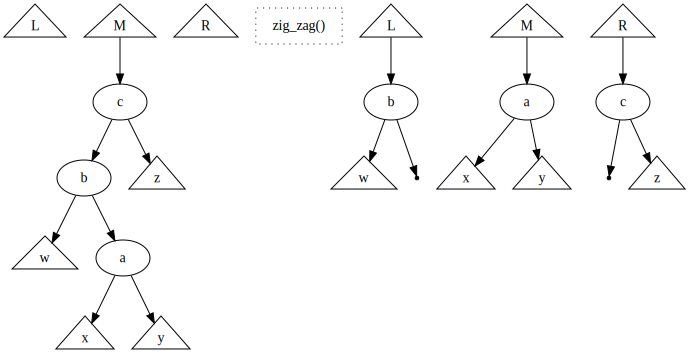

In [11]:
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", w1, a1); c1 = Node("c", b1, z1)
l1 = UnaryTree("L", None); m1 = UnaryTree("M", c1); r1 = UnaryTree("R", None)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", w2, None); c2 = Node("c", None, z2)
l2 = UnaryTree("L", b2); m2 = UnaryTree("M", a2); r2 = UnaryTree("R", c2)

dot = l1.graph([m1, r1, Method("zig_zag()"), l2, m2, r2])
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$, dabei werden $b$ und $c$ respektive an $L$ und $R$ angefügt, die ja jeweils kleiner bzw. größer als $a$ sind.

Wir definieren, diesmal unter Angabe beider Extrema

$$\text{Node}(c, \text{Node}(b, w, \text{Node}(a, x, y)), z).\text{zig_zag}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(b, w, \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L;$$
$$\text{new_min_}R := \text{Node}(c, \text{Nil}, z); \text{max_}R.\text{left} := \text{new_max_}R; (\text{new_max_}L, \text{Node}(a, x, y), \text{new_min_}R)$$

und erhalten auch beide neuen Extrema zurück.

In Code haben wir

In [12]:
def _zig_zag(self, max_less, min_greater):
    max_less.right = self.left
    max_less = self.left
    min_greater.left = self
    min_greater = self
    self = self.left.right
    max_less.right = None
    min_greater.left = None
    return max_less, self, min_greater

Node._zig_zag = _zig_zag
del _zig_zag

In umgekehrter Reihenfolge, d.h. der Elternknoten ist das rechte Kind, der Knoten das linke Kind, haben wir die Operation *Zag-Zig* mit

$$\text{Node}(c, w, \text{Node}(b, \text{Node}(a, x, y), z)).\text{zag_zig}(\text{max_}L, \text{min_}R) = \text{new_max_}L := \text{Node}(c, w, \text{Nil}); \text{max_}L.\text{right} := \text{new_max_}L;$$
$$\text{new_min_}R := \text{Node}(b, \text{Nil}, z); \text{min_}R.\text{left} := \text{new_min_}R; \text{Node}(a, x, y); (\text{new_max_}L, \text{Node}(a, x, y), \text{new_min_}R$$

In [13]:
def _zag_zig(self, max_less, min_greater):
    max_less.right = self
    max_less = self
    min_greater.left = self.right
    min_greater = self.right
    self = self.right.left
    max_less.right = None
    min_greater.left = None
    return max_less, self, min_greater

Node._zag_zig = _zag_zig
del _zag_zig

### Verkettung der Schritte

Das *Splayen* eines Knotens, also das Bewegen an die Wurzel, funktioniert durch das wiederholte Durchführen der Zig-, Zig-Zig- und Zig-Zag-Schritte (und umgekehrt), bis alle Elternknoten dieses Knotens beiseite gelegt sind.

Falls der gesuchte Knoten noch genau eine Ebene entfernt ist, so führen wir Zig bzw. Zag durch. In diesem Fall unterscheiden wir:

|Linkes Kind|Rechtes Kind|
|-----------|------------|
|Zig        |Zag         |

Falls er noch mindestens zwei Ebenen entfernt ist, so unterscheiden wir:

|                 |Linkes Kind|Rechtes Kind|
|-----------------|-----------|------------|
|**Linker Enkel** |Zig-Zig    |Zig-Zag     |
|**Rechter Enkel**|Zag-Zig    |Zag-Zag     |

oder formaler, wobei wir den gesuchten Knoten als $\text{sought}$ bezeichnen:

- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} = w \Rightarrow M.\text{splay_step}() = M.\text{zig}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} = x \Rightarrow M.\text{splay_step}() = M.\text{zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} < w \Rightarrow M.\text{splay_step}() = M.\text{zig_zig}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} > x \Rightarrow M.\text{splay_step}() = M.\text{zag_zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, \text{Node}(w, x, y), z) \land \text{sought} > w \Rightarrow M.\text{splay_step}() = M.\text{zig_zag}(\text{max_}L, \text{min_}R)$
- $M = \text{Node}(v, w, \text{Node}(x, y, z)) \land \text{sought} < x \Rightarrow M.\text{splay_step}() = M.\text{zag_zig}(\text{max_}L, \text{min_}R)$

Die Schritte werden wiederholt, bis an der Wurzel festgestellt werden kann, ob der gesuchte Knoten vorhanden ist. In diesem Fall fügen wir noch die Teilbäume von der neuen Wurzel an $L, R$ an und setzen $L, R$ als Teilbäume dieser neuen Wurzel.

- $M = \text{Node}(x, y, z) \land \lnot(\text{sought} = x \lor (x < \text{sought} \land y = \text{Nil}) \lor (x > \text{sought} \land z = \text{Nil})) \Rightarrow M.\text{splay}() = \text{max_}L, M, \text{min_}R := M.\text{splay_step}()$
- $M = \text{Node}(x, y, z) \land (\text{sought} = x \lor (x < \text{sought} \land y = \text{Nil}) \lor (x > \text{sought} \land z = \text{Nil})) \Rightarrow M.\text{splay}() = \text{max_}L.\text{right} := y; \text{min_}R.\text{left} := z; \text{Node}(x, L, R)$

Die Implementierung halten wir *iterativ*, um Funktionsaufrufe und Grenzen von Rekursionstiefe zu vermeiden:

In [14]:
def _splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if payload < self.payload:
            if self.left is None:
                break
            if payload < self.left.payload and self.left.left is not None:
                max_less, self, min_greater = self._zig_zig(max_less, min_greater)
                continue
            if payload > self.left.payload and self.left.right is not None:
                max_less, self, min_greater = self._zig_zag(max_less, min_greater)
                continue
            max_less, self, min_greater = self._zig(max_less, min_greater)
            break
        if payload > self.payload:
            if self.right is None:
                break
            if payload > self.right.payload and self.right.right is not None:
                max_less, self, min_greater = self._zag_zag(max_less, min_greater)
                continue
            if payload < self.right.payload and self.right.left is not None:
                max_less, self, min_greater = self._zag_zig(max_less, min_greater)
                continue
            max_less, self, min_greater = self._zag(max_less, min_greater)
            break
        break
    max_less.right = self.left
    min_greater.left = self.right
    self.left = set_aside.right
    self.right = set_aside.left
    return self

Node._splay = _splay
del _splay

Das nächste Beispiel zeigt, wie ein Splay aus einem schlechtestmöglich balancierten Baum einen deutlich besser balancierten Baum machen kann:

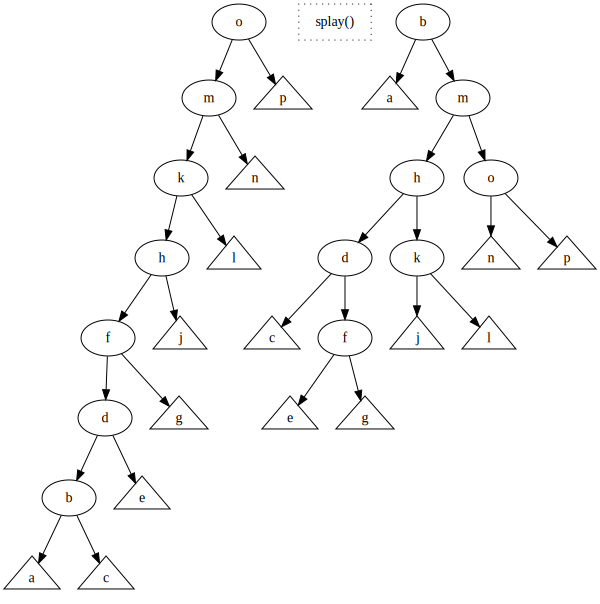

In [15]:
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None); g1 = Node("g", None, None)
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); p1 = Node("p", None, None)
b1 = Node("b", a1, c1); d1 = Node("d", b1, e1); f1 = Node("f", d1, g1); h1 = Node("h", f1, j1)
k1 = Node("k", h1, l1); m1 = Node("m", k1, n1); o1 = Node("o", m1, p1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None); g2 = Node("g", None, None)
j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); p2 = Node("p", None, None)
b2 = Node("b", a2, c2); d2 = Node("d", b2, e2); f2 = Node("f", d2, g2); h2 = Node("h", f2, j2)
k2 = Node("k", h2, l2); m2 = Node("m", k2, n2); o2 = Node("o", m2, p2)

dot = o1.graph([Method("splay()"), o2._splay("b")])
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, a2, c2, e2, g2, j2, l2, n2, p2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ein anderes Beispiel enthält alle Schritte außer Zag:

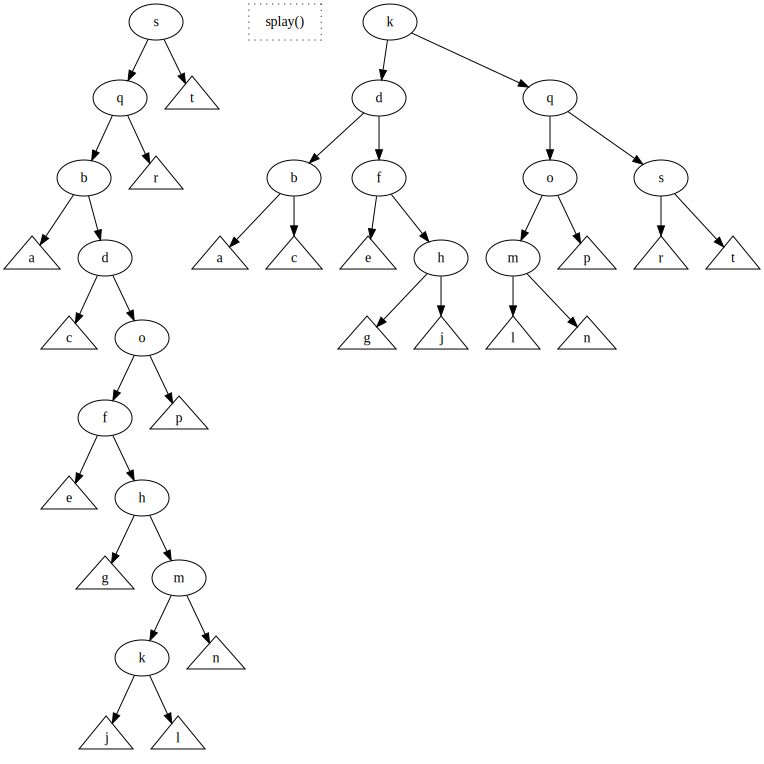

In [16]:
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); g1 = Node("g", None, None)
e1 = Node("e", None, None); p1 = Node("p", None, None); c1 = Node("c", None, None); a1 = Node("a", None, None)
r1 = Node("r", None, None); t1 = Node("t", None, None)
k1 = Node("k", j1, l1); m1 = Node("m", k1, n1); h1 = Node("h", g1, m1); f1 = Node("f", e1, h1)
o1 = Node("o", f1, p1); d1 = Node("d", c1, o1); b1 = Node("b", a1, d1); q1 = Node("q", b1, r1)
s1 = Node("s", q1, t1)

j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); g2 = Node("g", None, None)
e2 = Node("e", None, None); p2 = Node("p", None, None); c2 = Node("c", None, None); a2 = Node("a", None, None)
r2 = Node("r", None, None); t2 = Node("t", None, None)
k2 = Node("k", j2, l2); m2 = Node("m", k2, n2); h2 = Node("h", g2, m2); f2 = Node("f", e2, h2)
o2 = Node("o", f2, p2); d2 = Node("d", c2, o2); b2 = Node("b", a2, d2); q2 = Node("q", b2, r2)
s2 = Node("s", q2, t2)

dot = s1.graph([Method("splay()"), s2._splay("k")])
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, r1, t1, a2, c2, e2, g2, j2, l2, n2, p2, r2, t2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir betrachten zuletzt das folgende Beispiel, um Zag abgedeckt zu haben:

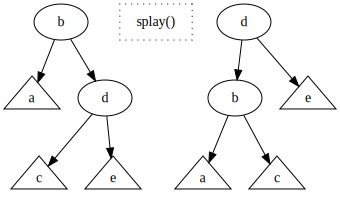

In [17]:
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None)
d1 = Node("d", c1, e1); b1 = Node("b", a1, d1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None)
d2 = Node("d", c2, e2); b2 = Node("b", a2, d2)

dot = b1.graph([Method("splay()"), b2._splay("d")])
for subtree in a1, c1, e1, a2, c2, e2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Schließlich definieren wir `_splay()` so, dass die Routinen für die einzelnen Schritte nicht in eigenen Methoden aufgerufen werden, um Aufrufe zu sparen. Wir überschreiben auch nicht die inneren Teilbäume der neuen Extrema mit `None`, da diese sowieso in jedem Schritt sowie am Ende überschrieben werden.

In [18]:
def _splay(self, payload):
    max_less = min_greater = set_aside = Node(None, None, None)
    while True:
        if payload < self.payload:
            if self.left is None:
                break
            if payload < self.left.payload and self.left.left is not None:
                tmp = self.left
                self.left = tmp.right
                tmp.right = self
                min_greater.left = tmp
                min_greater = tmp
                self = tmp.left
                continue
            if payload > self.left.payload and self.left.right is not None:
                max_less.right = self.left
                max_less = self.left
                min_greater.left = self
                min_greater = self
                self = self.left.right
                continue
            min_greater.left = self
            min_greater = self
            self = self.left
            break
        if payload > self.payload:
            if self.right is None:
                break
            if payload > self.right.payload and self.right.right is not None:
                tmp = self.right
                self.right = tmp.left
                tmp.left = self
                max_less.right = tmp
                max_less = tmp
                self = tmp.right
                continue
            if payload < self.right.payload and self.right.left is not None:
                max_less.right = self
                max_less = self
                min_greater.left = self.right
                min_greater = self.right
                self = self.right.left
                continue
            max_less.right = self
            max_less = self
            self = self.right
            break
        break
    max_less.right = self.left
    min_greater.left = self.right
    self.left = set_aside.right
    self.right = set_aside.left
    return self

Node._splay = _splay
del _splay

## Standardoperationen

Wir definieren für den Splay Tree als nächstes die grundlegenden Operationen auf Bäume: Einfügen, Löschen, auf das Vorhandensein eines Elements überprüfen, und auf das Leersein überprüfen. Wir bezeichnen im Folgenden den leeren Baum als $\text{Nil}$.

### Einfügen

Einfügen in einen Splay Tree funktioniert grundsätzlich genau wie das Einfügen in einen normalen geordneten binären Baum. Dabei müssen wir allerdings die Stapel von Elternreferenzen und Richtungen aufbauen.

Diese Stapel müssen wir zuerst konstruieren. Der erste Schritt lautet daher:

$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{insert}(p') = \text{Node}.\text{insert}(p', \text{Stack}(), \text{Stack}())$$

oder, für den leeren Baum:

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{insert}(p') = \text{Node}(p', \text{Nil}, \text{Nil})$$

Falls im anderen Fall die Nutzlast schon im Baum existiert, ist nur der gefundene Knoten zu splayen:

$$p' = p \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = x.\text{splay}(\text{parent_stack}, \text{direction_stack})$$

Falls die neue Nutzlast im Falle eines leeren Blattes eingesetzt werden kann, ist sie dort zu platzieren und der neue Knoten ist zu splayen:

$$p' < p \land l = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p', \text{Nil}, \text{Nil}).\text{splay}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left})$$
$$p' > p \land r = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p', \text{Nil}, \text{Nil}).\text{splay}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right})$$

Dabei müssen wir das Setzen des neuen Knotens als Kind nicht in die Definition aufnehmen, weil sich das schon durch den entsprechenden Splay ergibt.

Ansonsten haben wir die rekursiven Fälle:

$$p' < p \land l \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = l.\text{insert}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left}))$$
$$p' > p \land r \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{insert}(p', \text{parent_stack}, \text{direction_stack}) = r.\text{insert}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right}))$$

Wir benutzen wieder eine iterative Implementierung und überschreiben im rekursiven Fall einfach immer das gerade betrachtete Objekt.

In [26]:
def insert(self, payload):
    parent_stack = deque()
    direction_stack = deque()
    while True:
        if payload < self.payload:
            if self.left is None:
                leaf = Node(payload, None, None)
                parent_stack.append(self)
                direction_stack.append(True)
                leaf._splay(parent_stack, direction_stack)
                # new node is root after splay
                return leaf
            else:
                parent_stack.append(self)
                direction_stack.append(True)
                self = self.left
        elif payload == self.payload:
            self._splay(parent_stack, direction_stack)
            return self
        else:
            if self.right is None:
                leaf = Node(payload, None, None)
                parent_stack.append(self)
                direction_stack.append(False)
                leaf._splay(parent_stack, direction_stack)
                return leaf
            else:
                parent_stack.append(self)
                direction_stack.append(False)
                self = self.right

Node.insert = insert
del insert

Wir definieren – unter anderem zur Betrachtung des Falls des leeren Baumes – die Klasse `SplayTree`, die das Management des leeren Baums wie auch der Tatsache, dass sich bei einem Splay die Wurzel ändert, nach außen vereinfacht.

In [27]:
class SplayTree:
    def __init__(self):
        self.tree = None
    
    def insert(self, payload):
        if self.tree is None:
            self.tree = Node(payload, None, None)
        else:
            self.tree = self.tree.insert(payload)
    
    def delete(self, payload):
        pass
    
    def contains(self, paylaod):
        pass
    
    def is_empty(self):
        pass
    
    def show(self):
        return self.tree.show()

Einige Beispiele zeigen das Einsetzen von Knoten in Splay Trees:

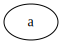

In [28]:
my_splay = SplayTree()
my_splay.insert("a")
my_splay.show()

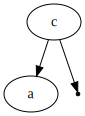

In [29]:
my_splay.insert("c")
my_splay.show()

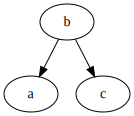

In [30]:
my_splay.insert("b")
my_splay.show()

### Entfernen

Wir definieren als nächstes das Entfernen eines Elementes. Wir konstruieren wieder zunächst die Stapel.

$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{delete}(p') = \text{Node}.\text{delete}(p', \text{Stack}(), \text{Stack}())$$

Beim leeren Baum gibt es nichts zu tun.

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{delete}(p') = \text{Nil}$$

Wir behandeln zunächst den Fall, in dem wir den zu löschenden Knoten gefunden haben und mindestens eines der Kinder dieses Knotens leer ist. Dann kann der andere Teilbaum einfach an diese Stelle gezogen werden. Darauf wird der Elternknoten des gelöschten Knotens gesplayt.

$p' = p \land l = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, r, r^*).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l^*, r).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l \neq \text{Nil} \land r = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{left} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l, r^*).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l \neq \text{Nil} \land r = \text{Nil} \land \lnot \text{parent_stack}.\text{is_empty}() \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{right} \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l^*, l).\text{splay}(\text{parent_stack}, \text{direction_stack})$$

Sollte dies an der Wurzel passieren, so ist der Knoten ohne Splay hochzuziehen.

$$p' = p \land l = \text{Nil} \land \text{parent_stack}.\text{is_empty}() \Rightarrow \text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = r$$
$$p' = p \land l \neq \text{Nil} \land r = \text{Nil} \land \text{parent_stack}.\text{is_empty}() \Rightarrow \text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = l$$

Schwieriger wird es, wenn der zu löschende Knoten zwei nichtleere Teilbäume hat. Dann setzen wir an die Stelle des zu löschenden Knotens das Maximum seines linken Teilbaums. Die Orndungsbedingung wird nicht verletzt, weil das Maximum des linken Teilbaums größer ist als alle Elemente des linken Teilbaums, aber kleiner als alle Elemente des rechten Teilbaums.

Wir definieren dafür $\text{del_ret_max}()$ (delete and return maximum). Die Funktion gibt ein Tupel von dem Maximum und dem neuen Baum zurück.

$$r = \text{Nil} \Rightarrow \text{Node}(p, l, r).\text{del_ret_max}() = (p, l)$$
$$r \neq \text{Nil} \land r.\text{del_ret_max}() = (p', r') \Rightarrow \text{Node}(p, l, r).\text{del_ret_max}() = (p', \text{Node}(p, l, r'))$$

Dann können wir beliebige Knoten entfernen mit

$p' = p \land l \neq \text{Nil} \land r \neq \text{Nil} \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{left} \land l.\text{del_ret_max}() = (\tilde{p}, \tilde{l}) \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, \text{Node}(\tilde{p}, \tilde{l}, r), r^*).\text{splay}(\text{parent_stack}, \text{direction_stack})$$
$p' = p \land l \neq \text{Nil} \land r \neq \text{Nil} \land \text{parent_stack}.\text{pop}() = \text{Node}(p^*, l^*, r^*) \land \text{direction_stack}.\text{pop}() = \text{right} \land l.\text{del_ret_max}() = (\tilde{p}, \tilde{l}) \Rightarrow$
$$\text{Node}(p, l, r).\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{Node}(p^*, l^*, \text{Node}(\tilde{p}, \tilde{l}, r)).\text{splay}(\text{parent_stack}, \text{direction_stack})$$

Bei den rekursiven Fällen haben wir:

$$p' < p \land l \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = l.\text{delete}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left}))$$
$$p' > p \land r \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = r.\text{delete}(p', \text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right}))$$

Schlussendlich ändern wir nichts, wenn der Knoten nicht existiert:

$$p' < p \land l = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{parent_stack}.\text{push}(x).\text{bottom}()$$
$$p' > p \land r = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{delete}(p', \text{parent_stack}, \text{direction_stack}) = \text{parent_stack}.\text{push}(x).\text{bottom}()$$

Wir benutzen wieder iterative Implementierungen.

In [31]:
def _del_ret_max(self):
    if self.right is None:
        return (self.payload, self.left)
    root = self
    while True:
        if self.right.right is None:
            maximum = self.right.payload
            self.right = self.right.left
            return (maximum, root)
        else:
            self = self.right

Node._del_ret_max = _del_ret_max
del _del_ret_max

def delete(self, payload):
    parent_stack = deque()
    direction_stack = deque()
    while True:
        if payload < self.payload:
            if self.left is None:
                parent_stack.append(self)
                return parent_stack[0]
            else:
                parent_stack.append(self)
                direction_stack.append(True)
                self = self.left
        elif payload == self.payload:
            if not parent_stack:
                if self.left is None:
                    return self.right
                elif self.right is None:
                    return self.left
                else:
                    self.payload, self.left = self.left._del_ret_max()
                    return self
            parent = parent_stack.pop()
            is_left_child = direction_stack.pop()
            if self.left is None:
                if is_left_child:
                    parent.left = self.right
                else:
                    parent.right = self.right
            elif self.right is None:
                if is_left_child:
                    parent.left = self.left
                else:
                    parent.right = self.left
            else:
                self.payload, self.left = self.left._del_ret_max()
            parent._splay(parent_stack, direction_stack)
            return parent
        else:
            if self.right is None:
                parent_stack.append(self)
                return parent_stack[0]
            else:
                parent_stack.append(self)
                direction_stack.append(False)
                self = self.right

Node.delete = delete
del delete

def delete(self, payload):
    if self.tree is not None:
        self.tree = self.tree.delete(payload)

SplayTree.delete = delete
del delete

Einige Beispiele zeigen das Entfernen von Elementen.

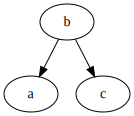

In [32]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.show()

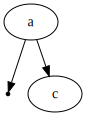

In [33]:
my_splay.delete("b")
my_splay.show()

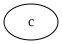

In [34]:
my_splay.delete("a")
my_splay.show()

### Finden

Wir definieren als nächstes das Überprüfen eines Baumes auf ein Element. Im Vergleich zu dieser Operation auf einem normalen geordneten binären Baum wird auch hier das gefundene Element gesplayt. In unserer Definition wird ein Tupel aus dem Vorhandensein und der neuen Wurzel zurückgegeben.

Wir konstruieren die Stapel (oder hören sofort auf, wenn der Baum leer ist):

$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{contains}(p') = \text{Node}.\text{contains}(p', \text{Stack}(), \text{Stack}())$$
$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{contains}(p') = (\text{false}, \text{Nil})$$

Wir bestätigen das Vorhandensein, wenn der Knoten gefunden ist, und splayen:

$$p' = p \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = (\text{true}, x.\text{splay}(\text{parent_stack}, \text{direction_stack}))$$

Wir verneinen das Vorhandensein, wenn der Knoten nicht existieren kann:

$$p' < p \land l = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = (\text{false}, \text{parent_stack}.\text{push}(x).\text{bottom}())$$
$$p' > p \land r = \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = (\text{false}, \text{parent_stack}.\text{push}(x).\text{bottom}())$$

Wir gehen tiefer in den Baum, wenn der Knoten in dem entsprechenden Teilbaum sein könnte:

$$p' < p \land l \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = l.\text{contains}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{left}))$$
$$p' > p \land r \neq \text{Nil} \Rightarrow \text{Node}(p, l, r) =: x; x.\text{contains}(p', \text{parent_stack}, \text{direction_stack}) = r.\text{contains}(\text{parent_stack}.\text{push}(x), \text{direction_stack}.\text{push}(\text{right}))$$

Wir implementieren wieder iterativ:

In [35]:
def contains(self, payload):
    parent_stack = deque()
    direction_stack = deque()
    while True:
        if payload < self.payload:
            if self.left is None:
                parent_stack.append(self)
                return (False, parent_stack[0])
            else:
                parent_stack.append(self)
                direction_stack.append(True)
                self = self.left
        elif payload == self.payload:
            self._splay(parent_stack, direction_stack)
            return (True, self)
        else:
            if self.right is None:
                parent_stack.append(self)
                return (False, parent_stack[0])
            else:
                parent_stack.append(self)
                direction_stack.append(False)
                self = self.right

Node.contains = contains
del contains

def contains(self, payload):
    if self.tree is not None:
        contains, self.tree = self.tree.contains(payload)
        return contains
    else:
        return False

SplayTree.contains = contains
del contains

Beispiele zeigen uns:

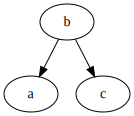

In [36]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.show()

In [37]:
my_splay.contains("a")

True

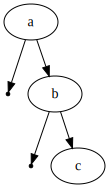

In [38]:
my_splay.show()

In [39]:
my_splay.contains("d")

False

### Leerüberprüfung

Wir definieren zuletzt, wie wir überprüfen, ob der Baum leer ist.

$$\text{Node} = \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{true}$$
$$\text{Node} \neq \text{Nil} \Rightarrow \text{Node}.\text{is_empty}() = \text{false}$$

Die Implementierung findet von `SplayTree` aus statt.

In [40]:
def is_empty(self):
    return self.tree is None

SplayTree.is_empty = is_empty
del is_empty

In [41]:
my_splay = SplayTree()
my_splay.is_empty()

True

In [42]:
my_splay.insert("a")
my_splay.is_empty()

False

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir den `SplayTree` als Menge, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich mit `set` unproblematisch.

In [43]:
def splay_primes(n):
    primes = SplayTree()
    for i in range(2, n + 1):
        primes.insert(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.delete(j)
    return primes

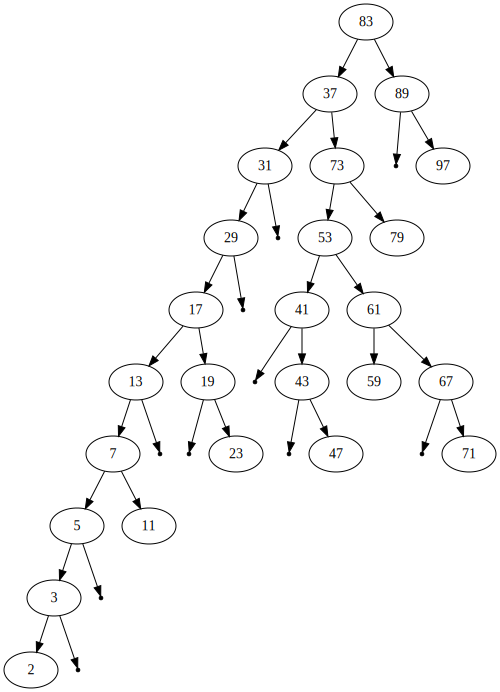

In [44]:
splay_primes(100).show()

Wir wiederholen die Implementierung mit dem eingebauten `set`.

In [45]:
def set_primes(n):
    primes = set()
    for i in range(2, n + 1):
        primes.add(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes -= set([j])
    return primes

In [46]:
print(set_primes(100))

{2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}


Wir betrachten nun vergleichend die Ausführungszeiten beider Varianten.

In [ ]:
splay_times = []
set_times = []

for i in range(10):
    start = process_time()
    splay_primes(10**4)
    stop = process_time()
    splay_times.append(stop - start)
    
    start = process_time()
    set_primes(10**4)
    stop = process_time()
    set_times.append(stop - start)

splay_median = median(splay_times)
set_median = median(set_times)
print(f"Median time of splay-based primes was {round(splay_median, 5)}s")
print(f"Median time of builtin set-based primes was {round(set_median, 5)}s")
if splay_median > set_median:
    print(f"Splaying was {round(splay_median / set_median, 2)} times slower")
else:
    print(f"Splaying was {round(set_median / splay_median, 2)} times faster")

Dabei ist zu beachten, dass wir zu diesem Zeitpunkt die Python-Implementierung mit einer C-Implementierung vergleichen.